In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline
import seaborn as sns
import annoy
import pandas as pd
from collections import Counter 
from annoy import AnnoyIndex
 
%load_ext autoreload
%autoreload 2
from ann_utils import ANN

In [2]:
# our selected best model
model = "2021-02-26_07:34:56.977606" # ResNet sigmoid activation + 3-layer classifier + larger classifier weight

In [3]:
embedding_path = f"models/{model}/fma_embeddings.npy"
label_path = f"models/{model}/fma_labels.npy"
filename_path = "data/fma_small_wav/filenames.npy"

# Genre classification on the FMA dataset
## On all FMA genres
* the FMA dataset contains some classes which are not in the GTZAN dataset

In [4]:
ann = ANN(embedding_path, label_path, filename_path, -1)
ann.supervised_evaluation(double_vote=False)

sub-track-classification acc: 62.0% 
top_2 sub-track-classification acc: 85.0%


working on TSNE. Might take a while
Oof. Done with TSNE.


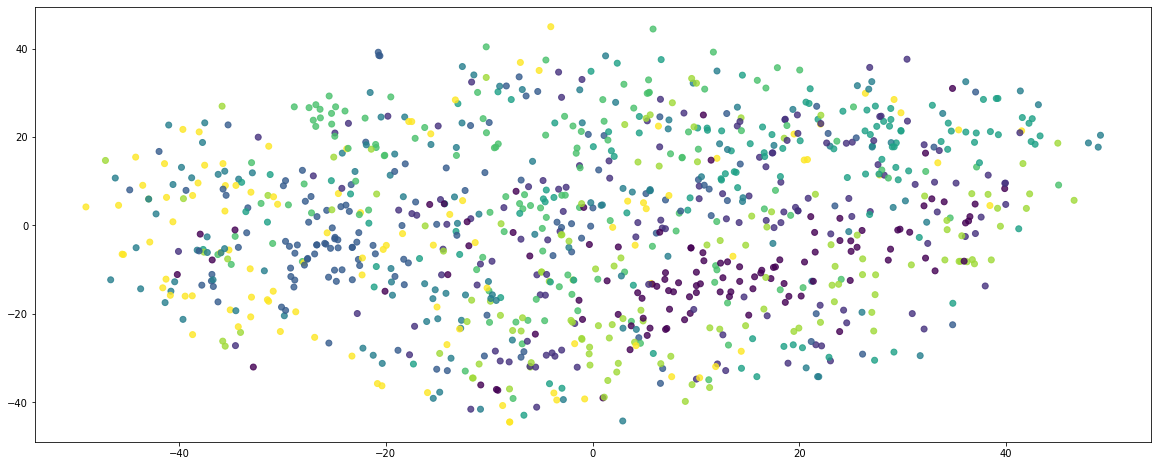

In [5]:
# this takes a very long time to compute (even longer than the evaluation)
ann.plot_tsne(size=1000) # how many random points you want to fit_transform 

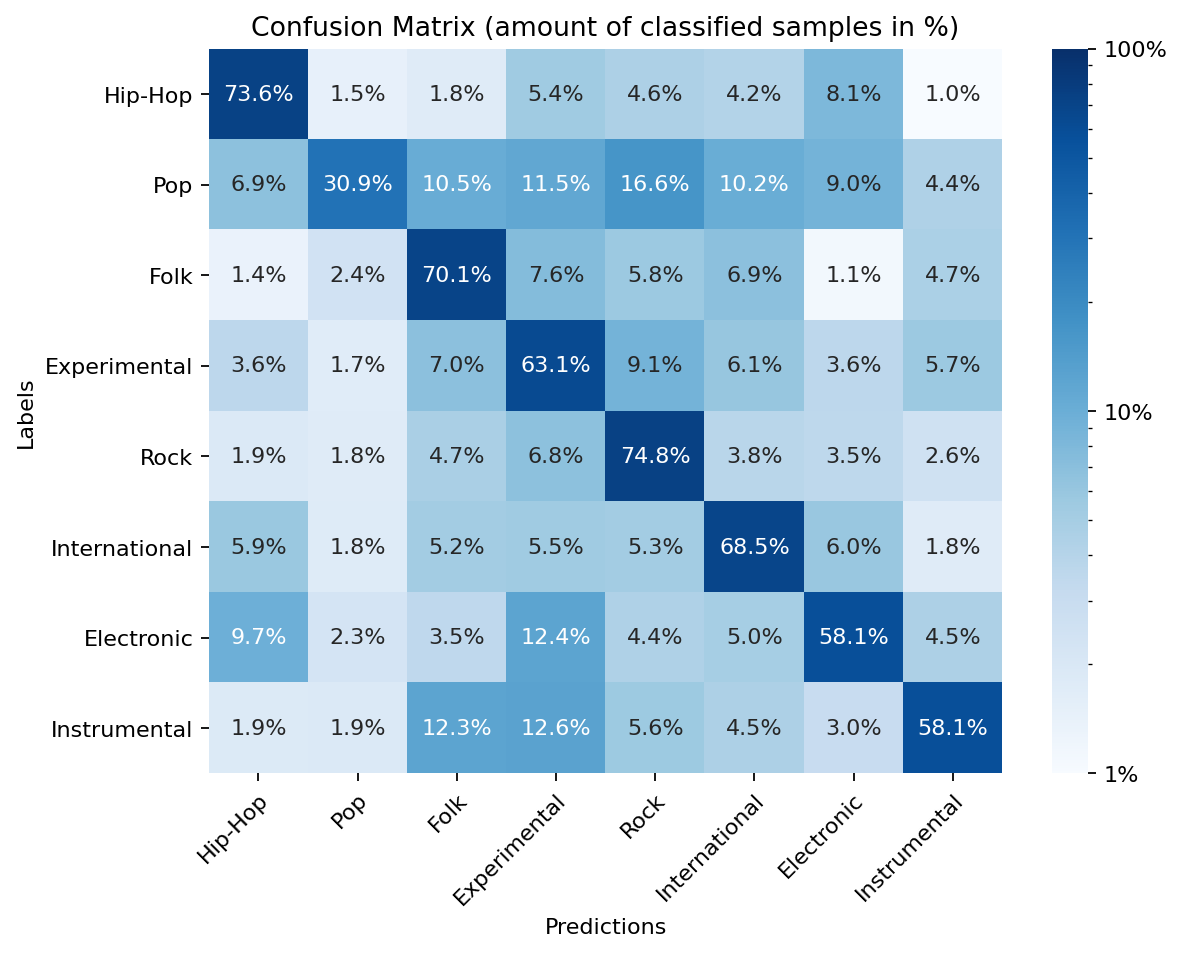

In [6]:
c_mat = ann.confusion_matrix

fig, ax = plt.subplots(figsize=(8, 6), dpi=160)
ax = sns.heatmap(c_mat/np.sum(c_mat, axis=1)[:,np.newaxis], ax = ax,
                 fmt='.1%', annot=True, cmap='Blues', norm=LogNorm(1e-2,1),
                xticklabels=ann.genre_names, yticklabels=ann.genre_names)

ax.set_ylabel("Labels")
ax.set_xlabel("Predictions")
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
plt.setp(ax.get_yticklabels(), rotation=0, ha="right",
         rotation_mode="anchor")
ax.set_title("Confusion Matrix (amount of classified samples in %)")

cbar = ax.collections[-1].colorbar  # Add a colorbar to the figure based on the image
cbar.set_ticks([0.01,0.1,1.0])
cbar.set_ticklabels(["1%","10%","100%"]);

In [7]:
report = ann.classification_report
df = pd.DataFrame.from_dict(report).transpose()
df.head(df.shape[0]-3)

,precision,recall,f1-score,support
Hip-Hop,0.700985,0.735507,0.717831,9970.0
Pop,0.697990,0.309000,0.428363,10000.0
Folk,0.609739,0.701200,0.652279,10000.0
Experimental,0.504843,0.631231,0.561007,9990.0
Rock,0.592798,0.748148,0.661474,9990.0
International,0.626737,0.685400,0.654757,10000.0
Electronic,0.628612,0.581481,0.604129,9990.0
Instrumental,0.702333,0.581191,0.636045,9995.0


In [8]:
df.tail(3)

,precision,recall,f1-score,support
accuracy,0.621593,0.621593,0.621593,0.621593
macro avg,0.633005,0.621645,0.614486,79935.000000
weighted avg,0.632996,0.621593,0.614448,79935.000000


## On the 3 FMA classes already known from the GTZAN dataset

In [9]:
# 3 genres cm
v1 = np.where(ann.labels == 0)[0] # Hip-Hop
v2 = np.where(ann.labels == 1)[0] # Pop
v3 = np.where(ann.labels == 4)[0] # Rock

idx = np.concatenate([v1, v2, v3])

relevant_embeddings = ann.base_population[idx]
relevant_labels = ann.labels[idx]
relevant_filenames = ann.filenames[idx]

In [10]:
ann_gtzan = ANN(embedding_path, label_path, filename_path, -1)

ann_gtzan.genre_names = ['Hip-Hop', 'Pop', 'Rock']

ann_gtzan.base_population = relevant_embeddings
ann_gtzan.labels = relevant_labels
ann_gtzan.filenames = relevant_filenames

# add population
ann_gtzan.annoy_index = AnnoyIndex(ann_gtzan.embedding_size, ann_gtzan.metric)
for sample_id, embedding in enumerate(ann_gtzan.base_population):
    ann_gtzan.annoy_index.add_item(sample_id, embedding) 

# build 
ann_gtzan.annoy_index.build(ann_gtzan.n_trees);

In [11]:
ann_gtzan.supervised_evaluation(double_vote=False)

sub-track-classification acc: 77.0% 
top_2 sub-track-classification acc: 97.0%


working on TSNE. Might take a while
Oof. Done with TSNE.


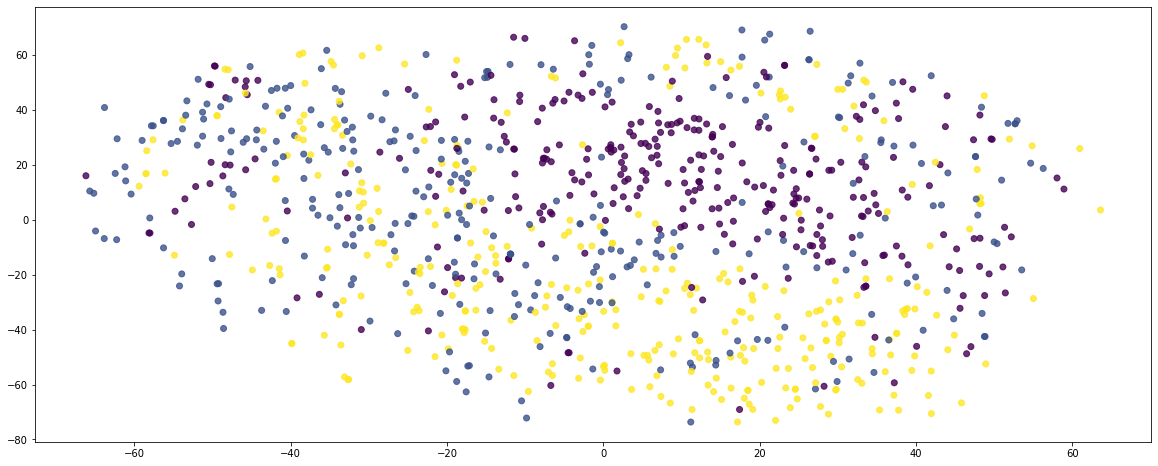

In [12]:
# this takes a very long time to compute (even longer than the evaluation)
ann_gtzan.plot_tsne(size=1000) # how many random points you want to fit_transform 

In [13]:
# we had to switch the label '4' of 'Rock' to '2' so that the confusion matrix is plotted right
idx_4 = np.where(ann_gtzan.labels == 4)
ann_gtzan.labels[idx_4[0]] = 2

from sklearn.metrics import confusion_matrix

unit_predictions = [pred[0] for pred in ann_gtzan.sub_predictions]
unit_predictions = np.array(unit_predictions)
# again the replacement of '4' by '2'
unit_predictions[np.where(unit_predictions==4)[0]] = 2
ann_gtzan.confusion_matrix = confusion_matrix(ann_gtzan.labels, unit_predictions, labels=range(len(ann_gtzan.genre_names))) 

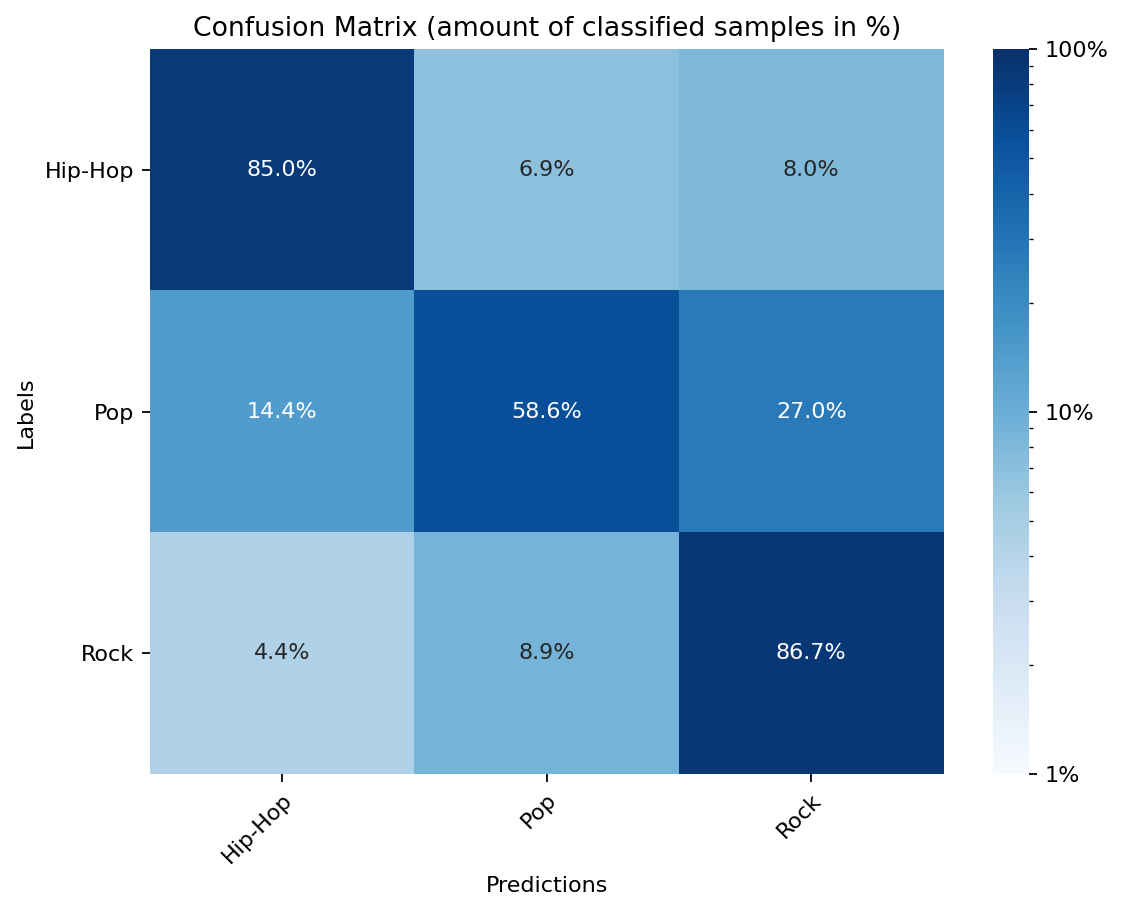

In [14]:
c_mat = ann_gtzan.confusion_matrix

fig, ax = plt.subplots(figsize=(8, 6), dpi=160)
ax = sns.heatmap(c_mat/np.sum(c_mat, axis=1)[:,np.newaxis], ax = ax,
                 fmt='.1%', annot=True, cmap='Blues', norm=LogNorm(1e-2,1),
                xticklabels=ann_gtzan.genre_names, yticklabels=ann_gtzan.genre_names)

ax.set_ylabel("Labels")
ax.set_xlabel("Predictions")
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
plt.setp(ax.get_yticklabels(), rotation=0, ha="right",
         rotation_mode="anchor")
ax.set_title("Confusion Matrix (amount of classified samples in %)")

cbar = ax.collections[-1].colorbar  # Add a colorbar to the figure based on the image
cbar.set_ticks([0.01,0.1,1.0])
cbar.set_ticklabels(["1%","10%","100%"]);

In [15]:
report = ann_gtzan.classification_report
df = pd.DataFrame.from_dict(report).transpose()
df.head(df.shape[0]-3)

,precision,recall,f1-score,support
Hip-Hop,0.826803,0.850853,0.838655,9970.0
Pop,0.788200,0.602500,0.682952,10000.0
Rock,0.719061,0.867768,0.786447,9990.0


In [16]:
df.tail(3)

,precision,recall,f1-score,support
accuracy,0.773598,0.773598,0.773598,0.773598
macro avg,0.778021,0.773707,0.769351,29960.000000
weighted avg,0.777992,0.773598,0.769276,29960.000000


# Bonus: FMA song classification on all \~8000 songs (\~80k snippets)

In [17]:
catch_single = list()
catch_double = list()
catch_triple = list()
preds = {}

# snippet-song matching
for sample_vec, filename in zip(ann.base_population, ann.filenames):
    predictions = ann.annoy_index.get_nns_by_vector(sample_vec, 10, include_distances=False)
    mc = np.array(Counter(ann.filenames[predictions]).most_common())
    
    catch_single.append(filename in mc[:1])
    catch_double.append(filename in mc[:2])
    catch_triple.append(filename in mc[:3])

In [18]:
prec_single = (np.sum(catch_single)/len(catch_single)) * 100
print(f'top-1 song-matching: {np.round(prec_single, 2)}%') 

top-1 song-matching: 76.41%


In [19]:
prec_double = (np.sum(catch_double)/len(catch_double)) * 100
print(f'top-2 song-matching: {np.round(prec_double, 2)}%') 

top-2 song-matching: 93.31%


In [20]:
prec_triple = (np.sum(catch_triple)/len(catch_triple)) * 100
print(f'top-3 song-matching: {np.round(prec_triple, 2)}%') 

top-3 song-matching: 98.98%
